### Project Overview
- You are required to analyze all of the Active Companies in the S&P 500
- Generate the Volatility of each company
- The market Cap of each company 
- The Expected Return of each company
- How does these companies tie into the Volatility market and what can we determine form this data

In [22]:
import pandas as pd
import numpy as np 
from pandas_datareader import data as web
import seaborn as sns

In [129]:
data = pd.read_csv("resources/companies.csv")

## Data Overview
- There are 505 entries in the data set, but there my be conpanies that my not exist in the set so we will acount for them

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Symbol  505 non-null    object
 1   Name    505 non-null    object
 2   Sector  505 non-null    object
dtypes: object(3)
memory usage: 12.0+ KB


## Stock Data 
- We will use pandas to get the stock data for each symbol in the list
- Will use data for the last 10 years if exists

In [25]:
failed = []
passed = []
stock_Data = pd.DataFrame()
for x in data["Symbol"]:
    try:
        stock_Data[x] = web.DataReader(x, data_source= "yahoo", start = "2010-1-1")["Adj Close"]
        passed.append(x)
    except (IOError, KeyError):
        msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        failed.append(x)
    

### Companies that failed
- Either does not exist or cannot be fetched by yahoo data reader
- We have 485 companies Passed 
- 20 failed 
- This is a good number to move forward with our analysis

In [28]:
len(failed)

20

In [29]:
len(passed)

485

In [291]:
stock_Data = pd.read_csv("resources/StockData.csv", parse_dates = True, index_col="Date")

### Calculating Volatility
- Calculating the Volatility for each Security

In [292]:
company_Vol= [stock_Data[x].pct_change().std() * np.sqrt(252) for x in stock_Data]

In [293]:
vol_for_period = pd.DataFrame(company_Vol, columns=["Vol"])

In [294]:
vol_for_period.index = passed

### Outlier
- Looks like there is one company disrupting the data set
- Let find that company and see if we should eliminate it
- looks like SCG is the issue- We will visit the web to make a decision on this company
- The Company is SCANA Corporation (SCG) 
- Loks like this company did not last long and the price dropped to 0 within a 1 year perios so we will eliminate it

In [295]:
stock_Data["SCG"].dropna()

Date
2015-07-16    1.018275e+26
2015-07-17    1.018275e+26
2015-07-20    1.018275e+26
2015-07-21    1.018275e+26
2015-07-22    1.018275e+26
                  ...     
2020-05-12    4.500000e-03
2020-05-13    4.500000e-03
2020-05-14    4.500000e-03
2020-05-15    4.500000e-03
2020-05-18    4.500000e-03
Name: SCG, Length: 1219, dtype: float64

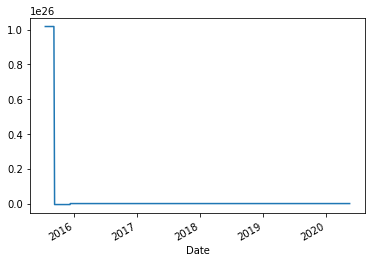

In [296]:
stock_Data["SCG"].plot()

In [297]:
stock_Data['AMZN'].pct_change().std() ** 252 ** 0.5

9.700138257652694e-28

In [298]:
vol_for_period.sort_values("Vol", ascending = True)

,Vol
MON,0.163335
JNJ,0.169479
KO,0.171567
PG,0.172565
PEP,0.174845
...,...
PCG,0.555253
AMD,0.579607
NKTR,0.579943
ARNC,1.677144


In [299]:
data[data.index == "ARNC"]

,Name,Sector,Vol,Vol
Symbol,,,,
ARNC,Arconic Inc.,Industrials,1.677144,1.677144


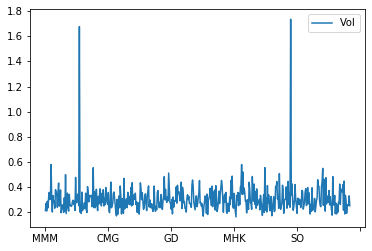

In [300]:
vol_for_period.plot()

In [301]:
vol_for_period.idxmax()

Vol    SCG
dtype: object

### S&P Average Volatility
- From the list below we can that that most of the companies in the s&P have an average volatility around 25%

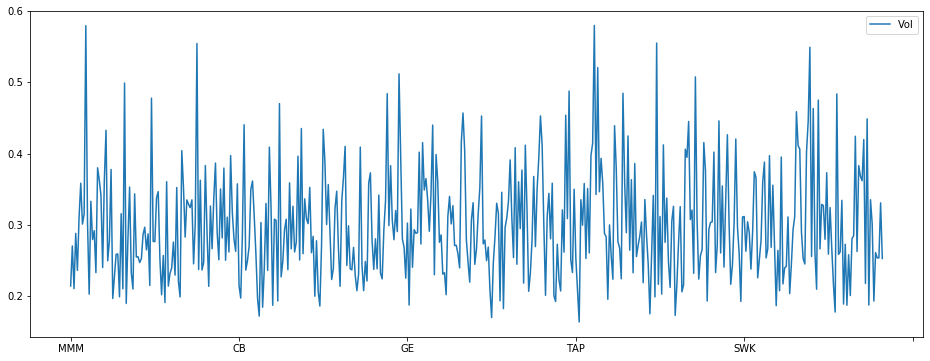

In [302]:
vol_for_period.drop(["SCG", "ARNC"]).plot(figsize = (16,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a34288990>]],
      dtype=object)

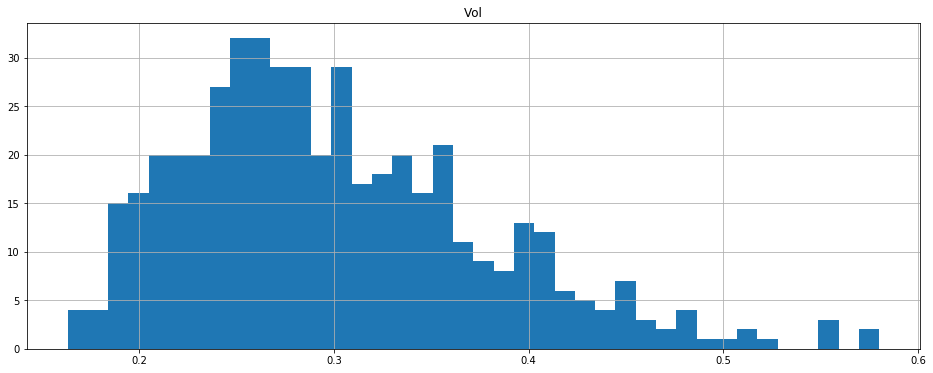

In [303]:
vol_for_period.drop(["SCG", "ARNC"]).hist(figsize = (16,6), bins = 40)

## Combining data
- Add the vol to the data set for the laast 10 years of data

### S&P as a Portfolio 
- What would happen if we had a portfolio that consisted of every company since 2010. What coupanies would have earned us the highest retirns and a 200,000 investment weighted Arbritrarly over the period
- Also what if we optomized this portfolio using a Markowitz Portfolio Oprimization. What portfolio would earn us the highest return
- INvestment data will be 2010-1-04 as a start

## Calculate Normal Returns
- We will first need to eliminate all stocks that have no values on our initial investment dates. 
- Would be difficult to calculate the returns of each stock that would have been in our portfilio
- After droping all the null values we are ready to create our portfolio that will consist of 426 companies since 2010

In [304]:
portfolio_data = stock_Data.dropna(axis=1)

In [305]:
portfolio_data.isnull().sum()

MMM     0
AOS     0
ABT     0
ACN     0
ATVI    0
       ..
XRX     0
XLNX    0
YUM     0
ZBH     0
ZION    0
Length: 426, dtype: int64

In [306]:
port_Tickers = portfolio_data.columns

In [307]:
portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2612 entries, 2010-01-04 to 2020-05-19
Columns: 426 entries, MMM to ZION
dtypes: float64(426)
memory usage: 8.5 MB


In [308]:
for t in portfolio_data.columns:
    portfolio_data[f"{t} normal returns"] = portfolio_data[t]/portfolio_data[t].iloc[0]

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Allocations
- LEts consider how we would weigh each security in the portfolio
- Will randomize the Allocation for each security in the portfolio
- And make sure they will add up to 100% of the portflio

In [380]:
weii = np.random.random(426)
weights = weii/weii.sum()

In [381]:
weights.sum()

1.0

### Calculating Allocations with Weights

In [382]:
port_Allocaitons = pd.DataFrame()
for stock, weight in zip(port_Tickers,weights):
    portfolio_data[f"{stock} allocation"] = portfolio_data[f"{stock} normal returns"] * weight
    port_Allocaitons[f"{stock} allocation"] = portfolio_data[f"{stock} normal returns"] * weight
    

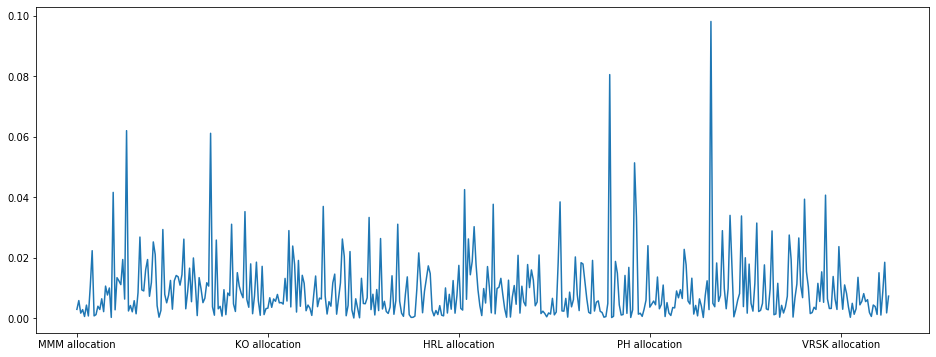

In [383]:
port_Allocaitons.loc["2020-5-19"].plot(figsize = (16,6))

### Leading Companies over a 10 year period 
- Top 20 companies are below in relative to alocations
- Netflix would have had the highest allocaton over a 10 year span 
- Agai nkeep in mind that this is arbritrary values of weights 
- Below we will take a look at 2000 different portfolios weighed randomly

In [384]:
port_Allocaitons.loc["2020-5-19"].sort_values(ascending = False).head(20)

REGN allocation    0.098152
NFLX allocation    0.080575
AMZN allocation    0.062028
AVGO allocation    0.061151
NVDA allocation    0.051380
HUM allocation     0.042520
ALGN allocation    0.041602
URI allocation     0.040689
TSCO allocation    0.039353
MA allocation      0.038455
IPGP allocation    0.037672
DG allocation      0.036957
CMG allocation     0.035233
CRM allocation     0.033998
SHW allocation     0.033808
ORLY allocation    0.033355
EL allocation      0.033311
SBUX allocation    0.031460
FISV allocation    0.031070
CNC allocation     0.031063
Name: 2020-05-19 00:00:00, dtype: float64

### Calculating Position Value 
- We will invest in the portfolio with a position of 200K

In [385]:
position = pd.DataFrame()
for x in port_Tickers:
    portfolio_data[f"{x} pos for stock"] = portfolio_data[f"{x} allocation"] * 200000
    position[f"{x} positon"] = portfolio_data[f"{x} allocation"] * 200000

In [386]:
len(position)

2612

#### Calculating total Position 
- Lets see the daily Total positon we hold for the period

In [387]:
portfolio_data["total positon"] = position.sum(axis = 1)

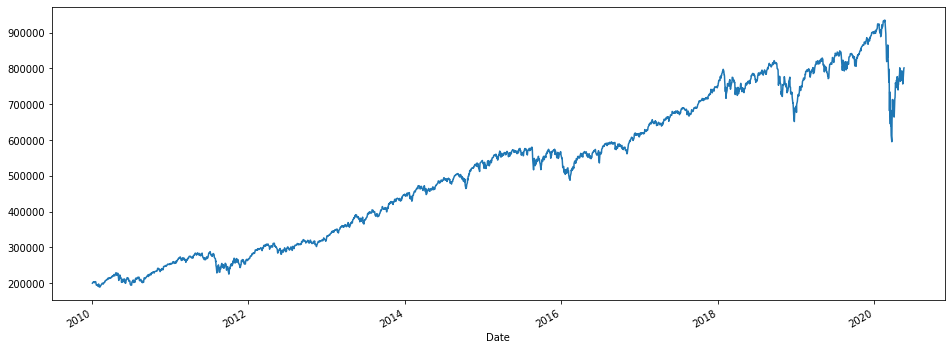

In [388]:
portfolio_data["total positon"].plot(figsize = (16,6))

### Highest Portfolio Position 
- would Have been on first day below 

In [392]:
portfolio_data["total positon"].sort_values(ascending = False)

Date
2020-02-19    935262.606557
2020-02-14    933840.689743
2020-02-20    933556.346362
2020-02-13    932901.571046
2020-02-12    932457.294048
                  ...      
2010-02-09    191580.852116
2010-02-10    191111.339834
2010-02-05    190201.365840
2010-02-04    189844.013462
2010-02-08    189061.338725
Name: total positon, Length: 2612, dtype: float64

### Calculating Daily Portfolio Returns
- We see our portfolio Volatility below
- Vol increase in 2010, late 2011, late 2015,early 2018, 2019 and recent 2020(COVID 19 epedemic)
- for from a educated guess since all companies in this portfolio makes up the S&P the overall/average vol should be close to that of the entire index. We will analyze this later

In [393]:
portfolio_data["daily returns"] = portfolio_data["total positon"].pct_change()

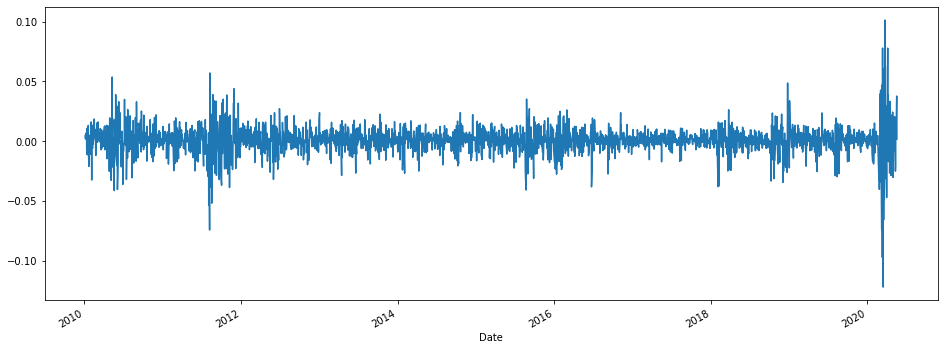

In [396]:
portfolio_data["daily returns"].plot(figsize = (16,6))

## Sharp Ratio
- Since we have the daily returns and the for the Portfilio we can calculate the Sharp Ratio for the portfilio

In [397]:
volatility = portfolio_data["daily returns"].std()

In [398]:
volatility

0.011690306465094086

In [399]:
mean_daily_return = portfolio_data["daily returns"].mean()

In [400]:
mean_daily_return

0.0006004231608403342

In [401]:
sharp = (mean_daily_return/volatility) * np.sqrt(252)

### Sharp Results
- We get at pretty low sharp ratio for this portfolio 
- This is the outcome of having some really volatilie companies and some not 
- Keep in mind this is again using arbritrary Weights 
- We will use markowitz portfolio optimiztion on this portfolio to see what is the max sharp we could get from this portfolio

In [402]:
sharp

0.8153269735383664

### Random Allocation of weights
- We will assign 2000 portfolios with random weights to try to get the max sharp

In [403]:
port_Tickers

Index(['MMM', 'AOS', 'ABT', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AAP', 'AMD', 'AES',
       ...
       'WHR', 'WMB', 'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'YUM', 'ZBH',
       'ZION'],
      dtype='object', length=426)

In [408]:
port_daily_returns = stock_Data.dropna(axis = 1).pct_change()

In [409]:
number_of_ports = 2000
all_weights = np.zeros((number_of_ports, len(port_Tickers)))
all_vol = np.zeros(number_of_ports)
all_returns = np.zeros(number_of_ports)
all_sharps = np.zeros(number_of_ports)

for ind in range(number_of_ports):
    weights = np.random.random(len(port_Tickers))
    weights = weights/weights.sum()
    all_weights[ind,:] = weights
    
    all_returns[ind] = np.sum(port_daily_returns.mean() *weights) * 252 
    all_vol[ind] = np.sqrt(np.dot(weights.T, np.dot(port_daily_returns.cov() * 252, weights)))
    all_sharps[ind] = all_returns[ind]/all_vol[ind]

KeyboardInterrupt: 

### Capturing Metrics
- will look at the Max Sharp
- Lowest Vol
- Highest Return